# Encoder Decoder

## Set up

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from dataset_creation.ImageCreation import ImageCreation

PyTorch version: 2.1.1+cu121


In [2]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [3]:
WIDTH, HEIGHT = 128, 128
STROKE_SIZE = 3
IMAGE_FACTOR = 1.1
EPOCHS: int = 50
BATCH_SIZE: int = 16

In [4]:
resources_folder = 'resources/sketchrnn'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)
class_size = {}

data = []

for class_name in classes:
    data_class = np.load(os.path.join(resources_folder, 'sketchrnn_' + class_name + '.npz'), allow_pickle=True, encoding="latin1")

    class_size[class_name] = len(data_class)
    data.append(data_class)

print(f'loaded numpy bitmaps, {nb_classes} classes')
print(len(data))
print(data[0].keys())
print(len(data[0]['train']))
print(len(data[0]['valid']))
print(len(data[0]['test']))

loaded numpy bitmaps, 8 classes
8
KeysView(NpzFile 'resources/sketchrnn/sketchrnn_apple.npz' with keys: test, train, valid)
70000
2500
2500


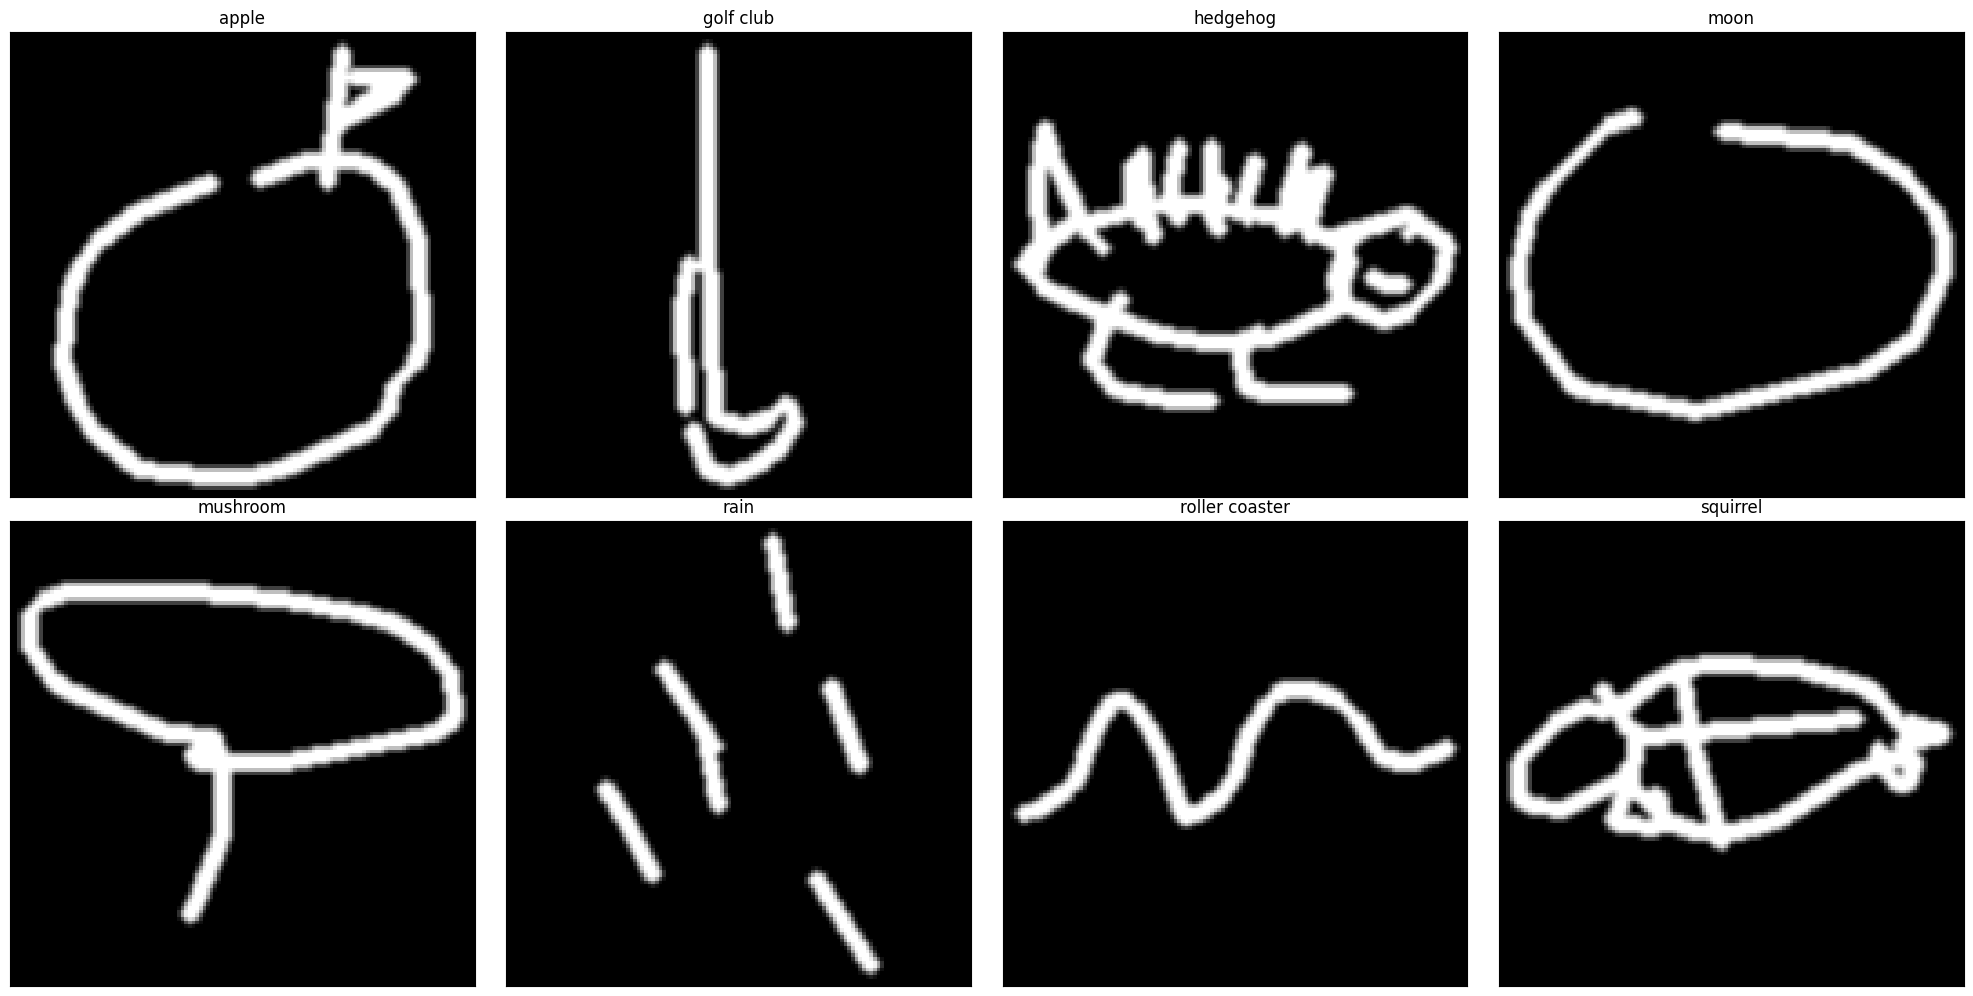

In [5]:
numb_rows = 2
numb_cols = 4

fig, axes = plt.subplots(numb_rows, numb_cols, figsize=(5*numb_cols, 5*numb_rows))
for i in range(nb_classes):
    index = random.randint(0, class_size[classes[i]])
    ax = axes[i//numb_cols, i%numb_cols]
    ax.imshow(ImageCreation.createImage(data[i]["train"][index], (WIDTH, HEIGHT), STROKE_SIZE, IMAGE_FACTOR), cmap='gray')
    ax.set_title(classes[i])

    # no ticks
    ax.set_xticks([])
    ax.set_yticks([])


plt.tight_layout()
plt.show()

## Dataset creation

In [6]:
from dataset_creation.DataManagerNpz import DataManagerNpz

data_manager = DataManagerNpz()

training_data, training_labels, validation_data, validation_labels, test_data, test_labels = data_manager.parse_data(data)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')
print(f'test dataset size : {len(test_data)}') 

training dataset size : 560000
validation dataset size : 20000
test dataset size : 20000


In [7]:
shuffled_training_data, shuffled_training_labels = data_manager.shuffle_dataset(training_data, training_labels)

shuffled_validation_data, shuffled_validation_labels = data_manager.shuffle_dataset(validation_data, validation_labels)

shuffled_test_data, shuffled_test_labels = data_manager.shuffle_dataset(test_data, test_labels)

In [8]:
from dataset_creation.StrokeImageDataset import StrokeImageDataset

len_subset = 2000
valid_test_subset = 500

training_set = StrokeImageDataset(
        data=shuffled_training_data[:len_subset], 
        labels=shuffled_training_labels[:len_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=True, normalize=True)

validation_set = StrokeImageDataset(
        data=shuffled_validation_data[:valid_test_subset], 
        labels=shuffled_validation_labels[:valid_test_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=True, normalize=True)

test_set = StrokeImageDataset(
        data=shuffled_test_data[:valid_test_subset], 
        labels=shuffled_test_labels[:valid_test_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=True, normalize=True)

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)
test_loaded_set = DataLoader(test_set, batch_size=BATCH_SIZE , shuffle=True)

In [9]:
from utils.dataset_distribution import dataset_distribution

print(f'training set distribution :\n{dataset_distribution(classes, training_set)}')
print(f'validation set distribution :\n{dataset_distribution(classes, validation_set)}')
print(f'test set distribution :\n{dataset_distribution(classes, test_set)}')

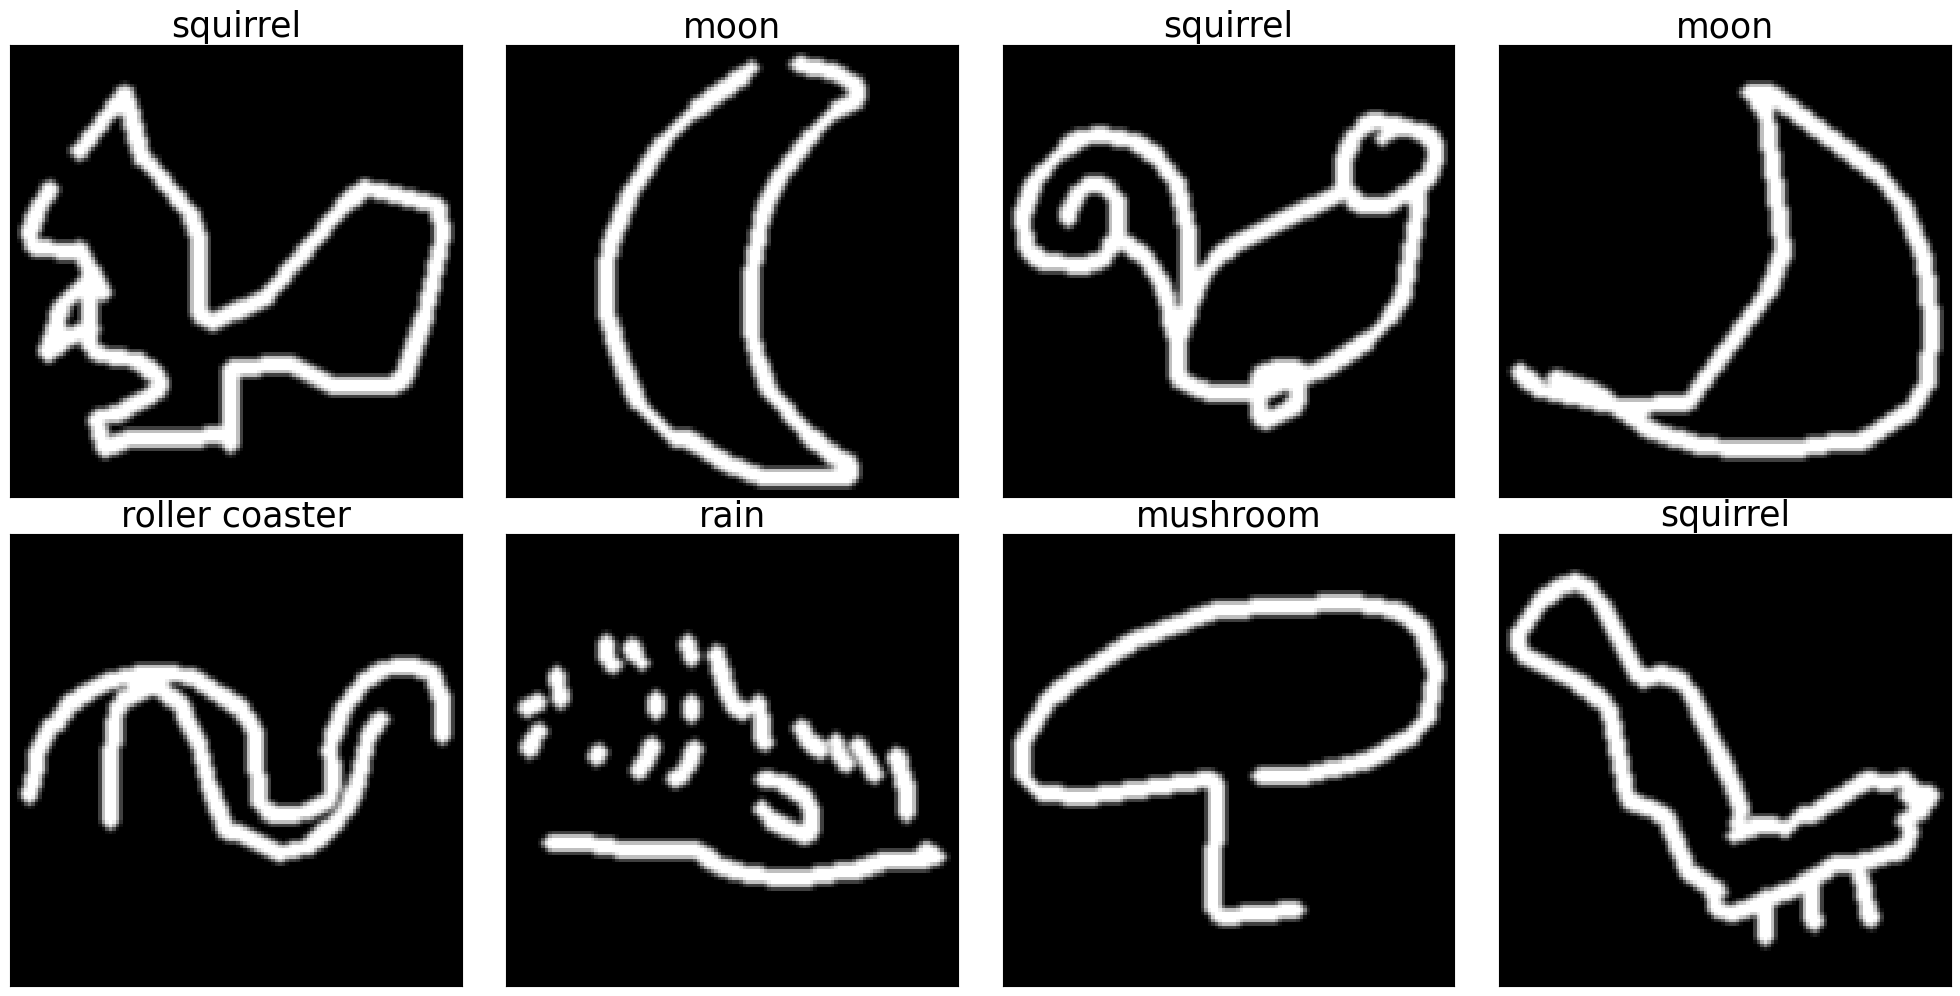

In [11]:
from utils.plot_random_images import plot_random_images

plot_random_images(training_set, classes)

## Autoencoder class

In [12]:
from src.conv_autoencoder_embed import ConvAutoencoderEmbed

## Try with simple model

In [13]:
architecture_1 = [1, 8, 16]
autoencoder_model = ConvAutoencoderEmbed(architecture_1, device, WIDTH, HEIGHT, classes, dropout=0.1, batch_norm=True)
autoencoder_model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)

In [14]:
# Print architecture 
autoencoder_model.print_model()

# Compression factor 
print(f'Compression factor: {(len(architecture_1)-2)*2}')

Sequential(
  (encoder_0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_relu_0): ReLU()
  (encoder_max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_dropout_0): Dropout(p=0.1, inplace=False)
  (encoder_batchnorm_0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Sequential(
  (decoder_2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_relu_2): ReLU()
  (encoder_upsample_2): Upsample(scale_factor=2.0, mode='nearest')
  (encoder_dropout_2): Dropout(p=0.1, inplace=False)
  (encoder_batchnorm_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_1): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 2


In [15]:
def tensor_to_numpy(tensor):
    return tensor.cpu().detach().numpy()

def numpy_to_tensor(numpy_array):
    return torch.from_numpy(numpy_array.astype(np.float32)).to(device)

def tensor_to_img(tensor):
    return tensor_to_numpy(tensor).reshape((WIDTH, HEIGHT))

In [16]:
# Call the function

autoencoder_model.train_autoencoder(training_loaded_set, validation_loaded_set, criterion, optimizer, EPOCHS)

loading weights from : weigths/ConvAutoencoderEmbed_2_epochs.pt
Epoch [3/50] T Loss: 0.0052 V Loss: 0.0035 T PSNR: 23.7911 T SSIM: 0.3589 V PSNR: 23.8127 V SSIM: 0.3588
Epoch [4/50] T Loss: 0.0045 V Loss: 0.0032 T PSNR: 24.5682 T SSIM: 0.3828 V PSNR: 24.5907 V SSIM: 0.3827
Epoch [5/50] T Loss: 0.0038 V Loss: 0.0027 T PSNR: 25.5144 T SSIM: 0.4129 V PSNR: 25.5368 V SSIM: 0.4128
Epoch [6/50] T Loss: 0.0032 V Loss: 0.0027 T PSNR: 26.1013 T SSIM: 0.4317 V PSNR: 26.1258 V SSIM: 0.4317


KeyboardInterrupt: 

In [ ]:
autoencoder_model.plot_psnr_ssim()

In [ ]:
autoencoder_model.show_images(training_set, validation_set)

In [ ]:
CHECK_BACTH_SIZE = 8000

training_check_dataloader= DataLoader(training_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)
validation_check_dataloader = DataLoader(validation_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)

In [ ]:
lowest_psnr, lowest_ssim = autoencoder_model.return_lowest_image_index_psnr_ssim(validation_check_dataloader)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

In [ ]:
autoencoder_model.show_lowest_psnr_ssim_image(validation_set, lowest_psnr, lowest_ssim)

# Show latent space

In [ ]:
from utils.latent_space_visualisation import latent_space_visualization

latent_space_visualization(autoencoder_model, training_loaded_set)

## Generating images

In [ ]:
from src.generator import ImageGenerator

image_generator = ImageGenerator(classes, device, autoencoder_model)

In [ ]:
mean_encoded_vectors = image_generator.generate_mean_encoded_vectors_per_classes(training_loaded_set)
image_generator.show_generated_images_per_mean_vectors(mean_encoded_vectors)

In [ ]:
noised_encoded_vectors = image_generator.generate_noised_mean_vectors(mean_encoded_vectors, 0.05)
image_generator.show_generated_images_per_mean_vectors(noised_encoded_vectors)

## Interpolation

### z_embed class (n) => z_embed' class (n)

In [ ]:
# get encoded of image 1
indice1 = 0

image_1, label1 = training_set[indice1]

image_1, label1 = numpy_to_tensor(image_1).to(device), torch.tensor(label1).to(device)

print(image_1.unsqueeze(0).shape)
pack1 = autoencoder_model(image_1.unsqueeze(0), label1.unsqueeze(0))


# iterate over all images to find the first image with the same label
indice2 = 1
image_2, label2 = None, None

while label2 != label1:
    image_2, label2 = training_set[indice2]
    indice2 += 1

image_2, label2 = numpy_to_tensor(image_2).to(device), torch.tensor(label2).to(device)

pack2 = autoencoder_model(image_2.unsqueeze(0), label2.unsqueeze(0))

latent_embed_space1 = pack1["encoded"].cpu().detach().numpy()
latent_embed_space2 = pack2["encoded"].cpu().detach().numpy()

vectors = []
titles = []

nb_interpolations = 8

# interpolate between image 1 and image 2
for i in range(nb_interpolations):
    vectors.append(latent_embed_space1 + (latent_embed_space2 - latent_embed_space1) * (i+1)/nb_interpolations)

    percentage = 50 - (i)/(nb_interpolations - 1) * 50
    if i >= nb_interpolations // 2:
        title = classes[label2] + " " +  str (round(100 - percentage * 2, 2)) + "%"
    else:
        title = classes[label1] + " " + str(round(percentage * 2, 2)) + "%"

    titles.append(title)

print(len(vectors))

image_generator.show_generated_images_per_vector(vectors, titles=titles, image_size=(WIDTH, HEIGHT))


### z_embed class (n) => z_embed' class (m, n != m)

In [ ]:
# get encoded of image 1
indice1 = 0

image_1, label1 = training_set[indice1]

image_1, label1 = numpy_to_tensor(image_1).to(device), torch.tensor(label1).to(device)
pack1 = autoencoder_model(image_1.unsqueeze(0), label1.unsqueeze(0))

# iterate over all images to find the first image with not the same label
image_2, label2 = image_1, label1
indice2 = 0
while label2 == label1:
    image_2, label2 = training_set[indice2]
    indice2 += 1

image_2, label2 = numpy_to_tensor(image_2).to(device), torch.tensor(label2).to(device)
pack2 = autoencoder_model(image_2.unsqueeze(0), label2.unsqueeze(0))

latent_embed_space1 = pack1["encoded"].cpu().detach().numpy()
latent_embed_space2 = pack2["encoded"].cpu().detach().numpy()

vectors = []
titles = []

nb_interpolations = 8

# interpolate between image 1 and image 2
for i in range(nb_interpolations):
    vectors.append(latent_embed_space1 + (latent_embed_space2 - latent_embed_space1) * (i+1)/nb_interpolations)

    percentage = 50 - (i)/(nb_interpolations - 1) * 50
    if i >= nb_interpolations // 2:
        title = classes[label2] + " " +  str (round(100 - percentage * 2, 2)) + "%"
    else:
        title = classes[label1] + " " + str(round(percentage * 2, 2)) + "%"

    titles.append(title)

print(len(vectors))

image_generator.show_generated_images_per_vector(vectors, titles=titles, image_size=(WIDTH, HEIGHT))

### z (class n) + embed_class n => z' (class m, n != m) + embed_class n

In [ ]:
# get encoded of image 1
indice1 = 0

image_1, label1 = training_set[indice1]

image_1, label1 = numpy_to_tensor(image_1).to(device), torch.tensor(label1).to(device)
pack1 = autoencoder_model(image_1.unsqueeze(0), label1.unsqueeze(0))

# iterate over all images to find the first image with not the same label
image_2, label2 = image_1, label1
indice2 = 0
while label2 == label1:
    image_2, label2 = training_set[indice2]
    indice2 += 1

image_2, label2 = numpy_to_tensor(image_2).to(device), torch.tensor(label2).to(device)
pack2 = autoencoder_model(image_2.unsqueeze(0), label2.unsqueeze(0))

latent_space1 = pack1["encoded_before"]
latent_space2 = pack2["encoded_before"]

embed_class1 = autoencoder_model.get_embed(label1.unsqueeze(0)).squeeze()

latent_embed_space1 = autoencoder_model.add_class_to_encoded(latent_space1, embed_class1).cpu().detach().numpy()
latent_embed_space2 = autoencoder_model.add_class_to_encoded(latent_space2, embed_class1).cpu().detach().numpy()

vectors = []
titles = []

nb_interpolations = 8

# interpolate between image 1 and image 2
for i in range(nb_interpolations):
    vectors.append(latent_embed_space1 + (latent_embed_space2 - latent_embed_space1) * (i+1)/nb_interpolations)

    percentage = 50 - (i)/(nb_interpolations - 1) * 50
    if i >= nb_interpolations // 2:
        title = classes[label2] + " " +  str (round(100 - percentage * 2, 2)) + "%"
    else:
        title = classes[label1] + " " + str(round(percentage * 2, 2)) + "%"

    titles.append(title)
    
image_generator.show_generated_images_per_vector(vectors, titles=titles, image_size=(WIDTH, HEIGHT))

### z (class n) + embed_class m => z' (class m, n != m) + embed_class m

In [ ]:
# get encoded of image 1
indice1 = 0

image_1, label1 = training_set[indice1]

image_1, label1 = numpy_to_tensor(image_1).to(device), torch.tensor(label1).to(device)
pack1 = autoencoder_model(image_1.unsqueeze(0), label1.unsqueeze(0))

# iterate over all images to find the first image with not the same label
image_2, label2 = image_1, label1
indice2 = 0
while label2 == label1:
    image_2, label2 = training_set[indice2]
    indice2 += 1

image_2, label2 = numpy_to_tensor(image_2).to(device), torch.tensor(label2).to(device)
pack2 = autoencoder_model(image_2.unsqueeze(0), label2.unsqueeze(0))

latent_space1 = pack1["encoded_before"]
latent_space2 = pack2["encoded_before"]

embed_class2 = autoencoder_model.get_embed(label2.unsqueeze(0)).squeeze()

latent_embed_space1 = autoencoder_model.add_class_to_encoded(latent_space1, embed_class2).cpu().detach().numpy()
latent_embed_space2 = autoencoder_model.add_class_to_encoded(latent_space2, embed_class2).cpu().detach().numpy()

vectors = []
titles = []

nb_interpolations = 8

# interpolate between image 1 and image 2
for i in range(nb_interpolations):
    vectors.append(latent_embed_space1 + (latent_embed_space2 - latent_embed_space1) * (i+1)/nb_interpolations)

    percentage = 50 - (i)/(nb_interpolations - 1) * 50
    if i >= nb_interpolations // 2:
        title = classes[label2] + " " +  str (round(100 - percentage * 2, 2)) + "%"
    else:
        title = classes[label1] + " " + str(round(percentage * 2, 2)) + "%"

    titles.append(title)

print(len(vectors))

image_generator.show_generated_images_per_vector(vectors, titles=titles, image_size=(WIDTH, HEIGHT))

### z (class n) + embed_class m => z' (class m) + embed_class n, n !=m

In [ ]:
# get encoded of image 1
indice1 = 0

image_1, label1 = training_set[indice1]

image_1, label1 = numpy_to_tensor(image_1).to(device), torch.tensor(label1).to(device)
pack1 = autoencoder_model(image_1.unsqueeze(0), label1.unsqueeze(0))

# iterate over all images to find the first image with the same label
indice2 = 1
image_2, label2 = None, None

while label2 != label1:
    image_2, label2 = training_set[indice2]
    indice2 +=1



# iterate over all images to find the first image with not the same label
embed_index = 0
while training_set[embed_index][1] == label2:
    embed_index += 1

image_2, label2 = numpy_to_tensor(image_2).to(device), torch.tensor(label2).to(device)

pack2 = autoencoder_model(image_2.unsqueeze(0), label2.unsqueeze(0))

latent_space1 = pack1["encoded_before"]
latent_space2 = pack2["encoded_before"]


label_other = torch.tensor(training_set[embed_index][1]).to(device)
embed_class_other = autoencoder_model.get_embed(label_other.unsqueeze(0)).squeeze()

latent_embed_space1 = autoencoder_model.add_class_to_encoded(latent_space1, embed_class_other).cpu().detach().numpy()
latent_embed_space2 = autoencoder_model.add_class_to_encoded(latent_space2, embed_class_other).cpu().detach().numpy()

vectors = []
titles = []

nb_interpolations = 8

# interpolate between image 1 and image 2
for i in range(nb_interpolations):
    vectors.append(latent_embed_space1 + (latent_embed_space2 - latent_embed_space1) * (i+1)/nb_interpolations)

    percentage = 50 - (i)/(nb_interpolations - 1) * 50
    if i >= nb_interpolations // 2:
        title = classes[label2] + " " +  str (round(100 - percentage * 2, 2)) + "%"
    else:
        title = classes[label1] + " " + str(round(percentage * 2, 2)) + "%"

    titles.append(title)

print(len(vectors))

image_generator.show_generated_images_per_vector(vectors, titles=titles, image_size=(WIDTH, HEIGHT))
